In [68]:
import h5py
import math
import random
import numpy as np
import scipy.signal as signal
import scipy.stats as stats
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [69]:
# 一些全局变量，放在这里好设置
# 说白了就是可以在合理范围之内改动的参数

# SHM-Data的位置
SHM_Data_Locate = "D://SHM-Data/"

# 连续小波变换的输入宽度
# 对现在用的SHM-Data来说够了，改大了就是徒增计算量
tof_widths = 101

# CF/RP板材的大小(mm)
# 没啥用，哈哈哈
plant_size = [500, 500]

# 12组传感器的xy坐标
sensor_locate = np.array([[450, 470], [370, 470], [290, 470], [210, 470], [130, 470], [50, 470], [450, 30], [370, 30], [290, 30], [210, 30], [130, 30], [50, 30]])

# 28个缺陷的位置
damage_locate = np.array([
    [50, 415], [65, 415], [50, 400], [65, 400],
    [250, 427], [265, 427], [250,412], [265, 412],
    [180, 345], [195, 345], [180,330], [195, 345],
    [320, 275], [335, 275], [320, 260], [335, 275],
    [130, 195], [145, 195], [130, 180], [130, 180],
    [435, 205], [450, 205], [435, 190], [450, 190],
    [250, 90], [265, 90], [250, 75], [265, 75]
])

# 选用的baseline
SHM_Data_baseline = '20180604T164628_baseline_1/pc_f100kHz.h5'

# MCMC总运行次数
# 越大越准，越大计算越慢
NT = 10000

# MCMC老化时间
# 只要你NT设置的足够大，老化时间是可以忽略的，可惜我懒得等计算
NB = 150

# 先验概率密度函数
# 正态分布的参数
[def_p_x, def_p_y, def_p_v] = [400, 400, 2000]
[def_p_x_scale, def_p_y_scale, def_p_v_scale] = [10, 10, 100]

In [70]:
# 使用连续小波变换获取ToF时间
# 输入catch信号和频道，输出ToF时间
def def_tof(def_tof_catch, def_tof_channel):
    def_tof_data = def_tof_catch[()][def_tof_channel, :]
    def_tof_widths = np.arange(1, tof_widths)
    def_tof_data_cwt = signal.cwt(def_tof_data, signal.morlet2, def_tof_widths)
    def_tof_data_cwt = np.square(np.abs(def_tof_data_cwt))
    def_tof_max_x, def_tof_max_y = np.where(def_tof_data_cwt == np.max(def_tof_data_cwt))
    def_tof_select = def_tof_data_cwt[def_tof_max_x, :]
    def_tof_select.resize(13108)
    def_tof_peak = signal.find_peaks(def_tof_select)
    def_tof_tof = def_tof_peak[0][1] - def_tof_peak[0][0]
    return def_tof_tof

In [71]:
# 对所有catch信号获取ToF时间，返回选中的几组
def def_multi_tof(dmt_locate, dmt_array):
    dmt_file = h5py.File(SHM_Data_Locate + dmt_locate, 'r')
    dmt_catch = dmt_file['/pitchcatch/catch']
    dmt_data_list = np.zeros((66,))
    for i in range(0, 66):
        dmt_data_list[i] = def_tof(dmt_catch, i)
    dmt_data_result = np.zeros((12, 12))
    dmt_data_point = 0
    for i in range(0, 12):
        for j in range(i + 1, 12):
            dmt_data_result[i][j] = dmt_data_list[dmt_data_point]
            dmt_data_result[j][i] = dmt_data_list[dmt_data_point]
            dmt_data_point += 1
    dmt_array_x = np.size(dmt_array, 0)
    dmt_data_select = np.zeros(dmt_array_x,)
    for i in range(dmt_array_x):
        dmt_data_select[i] = dmt_data_result[dmt_array[i][0]][dmt_array[i][1]]
    return dmt_data_select

In [72]:
# 先验概率密度函数之比
def fuc_p(fuc_p_theta1, fuc_p_theta2):
    fuc_p_x1 = fuc_p_theta1[0]
    fuc_p_y1 = fuc_p_theta1[1]
    fuc_p_v1 = fuc_p_theta1[2]
    fuc_p_x2 = fuc_p_theta2[0]
    fuc_p_y2 = fuc_p_theta2[1]
    fuc_p_v2 = fuc_p_theta2[2]
    fuc_pp1 = stats.norm.pdf(fuc_p_x1, def_p_x, scale=def_p_x_scale) * stats.norm.pdf(fuc_p_y1, def_p_y, scale=def_p_y_scale) * stats.norm.pdf(fuc_p_v1, def_p_v, scale=def_p_v_scale)
    fuc_pp2 = stats.norm.pdf(fuc_p_x2, def_p_x, scale=def_p_x_scale) * stats.norm.pdf(fuc_p_y2, def_p_y, scale=def_p_y_scale) * stats.norm.pdf(fuc_p_v2, def_p_v, scale=def_p_v_scale)
    fuc_pp = fuc_pp1 / fuc_pp2
    return min(1, fuc_pp)

In [73]:
# 计算理论与实际的误差
def fuc_q(fuc_q_theta, def_q_tof, def_q_array):
    xd = fuc_q_theta[0]
    yd = fuc_q_theta[1]
    vg = fuc_q_theta[2]
    count = 0
    def_q_size = np.size(def_q_array, 0)
    for i in range(def_q_size):
        count += np.square(def_q_tof[1] - np.sqrt(np.square(xd - sensor_locate[def_q_array[i][0]][0]) + np.square(yd - sensor_locate[def_q_array[i][0]][1])) / vg - np.sqrt(np.square(xd - sensor_locate[def_q_array[i][1]][0]) + np.square(yd - sensor_locate[def_q_array[i][1]][1])) / vg)
    return count

In [74]:
# 返回符合逆伽马分布的随机数
def fuc_ig(fuc_ig_theta, def_ig_tof, def_ig_array):
    return invgamma.rvs(2.5, scale=(1 / fuc_q(fuc_ig_theta, def_ig_tof, def_ig_array)))

In [75]:
# MCMC方法本体
def def_mcmc(def_mcmc_tof, def_mcmc_array):
    def_theta = np.zeros((NT,3))
    def_theta[0] = [250, 250, 3000]
    LK = [1, 1, 1]
    for i in range(1, NT):
        theta_1 = def_theta[i - 1][0] + 2 * LK[0] * (2 * random.random() - 1)
        theta_2 = def_theta[i - 1][1] + 2 * LK[1] * (2 * random.random() - 1)
        theta_3 = def_theta[i - 1][2] + 2 * LK[2] * (2 * random.random() - 1)
        theta_k = [theta_1, def_theta[i - 1][1], def_theta[i - 1][2]]
        alpha = fuc_p(theta_k, [def_theta[i - 1][0], def_theta[i - 1][1], def_theta[i - 1][2]])
        # alpha = fuc_p2(theta_k, [def_theta[i - 1][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_array)
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i - 1][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][0] = theta_1
            LK[0] = LK[0] * 1.01
        else:
            def_theta[i][0] = def_theta[i - 1][0]
            LK[0] = LK[0] / 1.07
        theta_k = [def_theta[i][0], theta_2, def_theta[i - 1][2]]
        alpha = fuc_p(theta_k, [def_theta[i][0], def_theta[i - 1][1], def_theta[i - 1][2]])
        # alpha = fuc_p2(theta_k, [def_theta[i][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_array)
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i][0], def_theta[i - 1][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][1] = theta_2
            LK[1] = LK[1] * 1.01
        else:
            def_theta[i][1] = def_theta[i - 1][1]
            LK[1] = LK[1] / 1.07
        theta_k = [def_theta[i][0], def_theta[i][1], theta_3]
        alpha = fuc_p(theta_k, [def_theta[i][0], def_theta[i][1], def_theta[i - 1][2]])
        # alpha = fuc_p2(theta_k, [def_theta[i][0], def_theta[i][1], def_theta[i - 1][2]], def_mcmc_array)
        r = alpha * math.exp(-0.5 * fuc_ig(def_theta[i - 1], def_mcmc_tof, def_mcmc_array) * (fuc_q(theta_k, def_mcmc_tof, def_mcmc_array) - fuc_q([def_theta[i][0], def_theta[i][1], def_theta[i - 1][2]], def_mcmc_tof, def_mcmc_array)))
        R = random.random()
        if R < r:
            def_theta[i][2] = theta_3
            LK[2] = LK[2] * 1.01
        else:
            def_theta[i][2] = def_theta[i - 1][2]
            LK[2] = LK[2] / 1.07
    return def_theta

In [76]:
# 制图函数，但是有点小问题
def def_plot_fig(def_pf_theta, def_pf_title):
    def_pf_fig, (def_pf_ax1, def_pf_ax2, def_pf_ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
    def_pf_x = np.linspace(0, NT-1, NT)
    def_pf_y1 = def_pf_theta[:, 0]
    def_pf_y2 = def_pf_theta[:, 1]
    def_pf_ax1.set_title('MCMC samples for\ncoordinates of damage location')
    def_pf_ax1.plot(def_pf_x, def_pf_y1, label='x-coordinate')
    def_pf_ax1.plot(def_pf_x, def_pf_y2, label='y-coordinate')
    def_pf_ax1.legend()
    def_pf_ax1.set_ylim([0, plant_size[0]])
    def_pf_ax1.set_xlabel('simples')
    def_pf_ax1.set_ylabel('location coordinates(mm)')

    def_pf_x_joint, def_pf_x_bins = np.histogram(def_pf_theta[:, 0], bins = np.arange(0, plant_size[0] + 1, 1))
    def_pf_y_joint, def_pf_y_bins = np.histogram(def_pf_theta[:, 1], bins = np.arange(0, plant_size[1] + 1, 1))
    def_pf_x_joint.flatten()
    def_pf_y_joint.flatten()
    def_pf_pdf_joint = np.outer(def_pf_y_joint, def_pf_x_joint)
    def_pf_im2 = def_pf_ax2.imshow(def_pf_pdf_joint / np.square(NT), cmap = 'viridis')
    def_pf_ax2.invert_yaxis()
    def_pf_ax2.set_title('MCMC joint PDF of\nthe identified possible damage location')
    def_pf_ax2.set_xlabel('x-coordinate')
    def_pf_ax2.set_ylabel('y-coordinate')
    def_pf_divider = make_axes_locatable(def_pf_ax2)
    def_pf_cax = def_pf_divider.append_axes('right', size='5%', pad=0.05)
    def_pf_fig.colorbar(def_pf_im2, cax=def_pf_cax, orientation='vertical')

    def_pf_prior = np.linspace(0, plant_size[0] + 1, plant_size[0] + 1)
    def_pf_x_prior = stats.norm.pdf(def_pf_prior, def_p_x, scale=def_p_x_scale)
    def_pf_y_prior = stats.norm.pdf(def_pf_prior, def_p_y, scale=def_p_y_scale)
    def_pf_pdf_prior = np.outer(def_pf_y_prior, def_pf_x_prior)
    def_pf_im3 = def_pf_ax3.imshow(def_pf_pdf_prior, cmap = 'viridis')
    def_pf_ax3.invert_yaxis()
    def_pf_ax3.set_title('MCMC prior PDF of\nthe identified possible damage location')
    def_pf_ax3.set_xlabel('x-coordinate')
    def_pf_ax3.set_ylabel('y-coordinate')
    def_pf_divider = make_axes_locatable(def_pf_ax3)
    def_pf_cax = def_pf_divider.append_axes('right', size='5%', pad=0.05)
    def_pf_fig.colorbar(def_pf_im3, cax=def_pf_cax, orientation='vertical')

    def_pf_fig.suptitle('MCMC method: ' + def_pf_title)
    def_pf_fig.tight_layout()

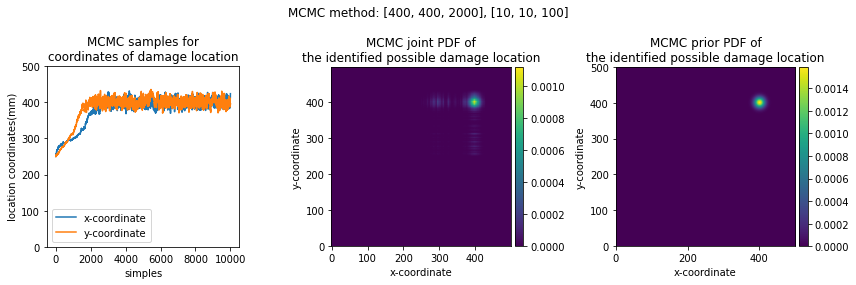

In [77]:
locate = "20180605T150315_D9/pc_f100kHz.h5"
select = np.array([[0, 1], [0, 2], [0, 3], [0, 4], [0, 5], [0, 6], [0, 7], [0, 8], [0, 9], [0, 10], [0, 11]])

tof = def_multi_tof(locate, select)
theta = def_mcmc(tof, select)
def_plot_fig(theta, '[400, 400, 2000], [10, 10, 100]')